# Spooky author classification challenge

- Predict the author based on snippets from their books.

In [406]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer 

from sklearn.preprocessing import StandardScaler,LabelEncoder


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, log_loss
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from keras.models import Model, Sequential
from keras.layers import Dense, Input,Dropout, Embedding, LSTM, Bidirectional, Activation, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing.text import one_hot, Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
import keras.backend as K
from keras.utils import np_utils

In [407]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
sample_sub = pd.read_csv('../input/sample_submission.csv')

In [408]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [409]:
print(train.shape)
print(test.shape)

(19579, 3)
(8392, 2)


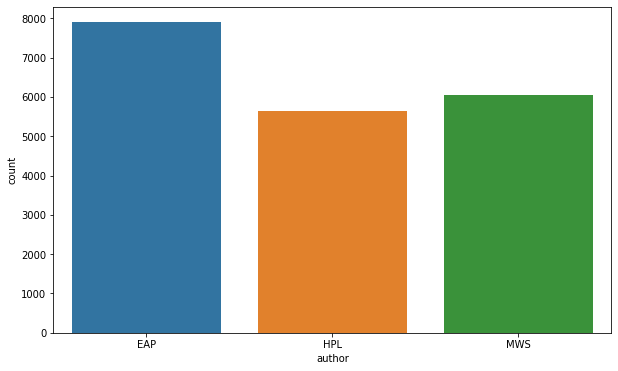

In [410]:
plt.figure(figsize = (10,6))
sns.countplot(train.author);

There's only a slight imbalance in the target class.

- **Map the author name abbreviations to integers.**

In [411]:
lbl_enc = LabelEncoder()
lbl_enc.fit(train.author)
train.loc[:, 'author'] = lbl_enc.transform(train.author)

### Text preprocessing
- Remove stopwords
- Lemmatize

In [412]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'([a-zA-Z]+)') 



def get_wordnet_pos(word):
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

def preprocess_text(text):
    '''
    This function preprocesses the comments and sets them up for vectorization.
    Input: comment string
    Returns: A string after converting the words to lowercase, removing punctuations, and lemmatizing each word
    '''
    words = [w for w in tokenizer.tokenize(text.lower()) if not w in stop_words]  # convert to lowercase and remove stopwords
##    words = [w for w in words if len(w)>2] # remove words less than 3 letters long, not used here
    lemmatized_text = ' '.join([lemmatizer.lemmatize(w, pos= get_wordnet_pos(w)) for w in words]) ## lemmatization
    return lemmatized_text

In [413]:
# Apply the preprocessing steps to the train text adn the test text
train.loc[:, 'text'] = train.text.apply(lambda text: preprocess_text(text))
test.loc[:, 'text'] = test.text.apply(lambda text: preprocess_text(text))

In [414]:
train.text.apply(lambda snippet: len(snippet)).describe()

count    19579.000000
mean        88.644568
std         65.975348
min          0.000000
25%         46.000000
50%         76.000000
75%        116.000000
max       2854.000000
Name: text, dtype: float64

- The texts have a mean length of ~ 88 characters.
- Few texts have zero length because they consist only of stopwords. We would remove those training examples since they are redundant.

In [415]:
ind_to_drop = np.where(train.text.apply(lambda s: len(s)==0))[0]
ind_to_drop

array([ 477, 1023, 3601, 8654])

In [416]:
train = train.drop(ind_to_drop,axis=0)

max length: 2854


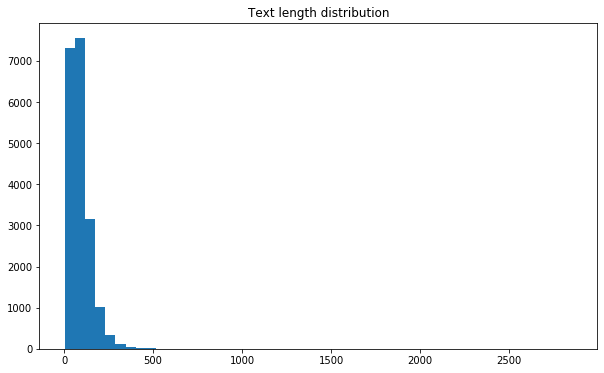

In [417]:
# Distribution of the text lengths (characters)

MAX_LENGTH = max(map(len, train.text))
print("max length:", MAX_LENGTH)
plt.figure(figsize = (10,6))
plt.title('Text length distribution')
plt.hist(list(map(len, train.text)), bins=50);

### Train-test split

In [418]:
X_train, X_test, y_train, y_test = train_test_split(train, train.author, test_size=0.2, 
                                                  shuffle=True, random_state=999, stratify = train.author)

### Vectorizer
- I've tried both TF-IDF and Count vectorizer.

In [419]:
# Consider unigrams and bi-grams, consider only top 10000 tokens.


tfidf = TfidfVectorizer(ngram_range = (1,2), strip_accents= 'unicode',
                       max_df= 0.8, min_df = 1, analyzer= 'word', 
                       max_features = 10000, sublinear_tf=True)

count_vec = CountVectorizer(ngram_range = (1,2), strip_accents= 'unicode',
                       max_df= 0.8, min_df = 1, analyzer= 'word', 
                       max_features = 10000)
## Fit on the training set
tfidf.fit(X_train.text)
count_vec.fit(X_train.text)

# Transform both the training set and the test set with the transformer
tfidf_train = tfidf.transform(X_train.text)
tfidf_test = tfidf.transform(X_test.text)

countvec_train = count_vec.transform(X_train.text)
countvec_test = count_vec.transform(X_test.text)

In [420]:
print(tfidf_train.shape)
print(tfidf_test.shape)
print(countvec_train.shape)
print(countvec_test.shape)

(15660, 10000)
(3915, 10000)
(15660, 10000)
(3915, 10000)


In [421]:
def get_top_n_tokens(vectorizer, vectorizer_name, df, top_n = 5):

    feature_names = vectorizer.get_feature_names()
    scores = np.sum(df.A, axis=0,keepdims=False)
    p=[]
    for tag, score in zip(feature_names, scores):
        p.append((tag, score))
    scores_df = pd.DataFrame(p,columns=['token', '%s score'%(vectorizer_name)]).sort_values(by = '%s score'%(vectorizer_name), ascending=False)
    return scores_df.head(top_n)

In [422]:
get_top_n_tokens(tfidf, 'tfidf', tfidf_train, top_n = 5)

,token,tfidf score
6148,one,180.002680
7517,say,169.280817
1731,could,159.789071
9287,upon,156.295431
9864,would,148.538631


In [423]:
get_top_n_tokens(count_vec, 'Count_vec', countvec_train, top_n = 5)

,token,Count_vec score
6148,one,1337
9287,upon,1150
1731,could,1077
7517,say,984
9864,would,962


### Predictive modelling

In [424]:
def grid_search(clf, parameters, X, y, n_jobs=-1, n_folds=5, score_func=None,verbose=0):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func,verbose =verbose)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, cv=5, verbose =verbose)
    gs.fit(X, y)
    print ("Best parameter values: {}\n Best mean CV score = {:.4} and std. dev. = {:.4}".format(gs.best_params_ , 
                                                                      gs.best_score_, 
                                                                      gs.cv_results_['std_test_score'][gs.best_index_]))
    best = gs.best_estimator_
    return best

def show_metrics(y_test,y_pred, y_pred_proba):
    print(classification_report(y_test, y_pred ))
    display(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                         columns= ['Predicted EAP', 'Predicted HPL', 'predicted MWS'], 
                         index = ['Actual EAP', 'Actual HPL', 'Actual MWS']))
    print('The multiclass logloss is {}'.format(log_loss(y_test, y_pred_proba)))
    
mlogloss = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

#### Naive Bayes

In [425]:
clf_mulNB = MultinomialNB()
parameters = {'alpha': np.arange(0.01, 0.1,0.01)}
mulNB_model = grid_search(clf_mulNB, parameters, tfidf_train, y_train, n_folds=5, score_func= mlogloss)

Best parameter values: {'alpha': 0.04}
 Best mean CV score = -0.4534 and std. dev. = 0.007596


In [426]:
print("------------- Naive Bayes -----------")
show_metrics(y_test, mulNB_model.predict(tfidf_test), mulNB_model.predict_proba(tfidf_test))

------------- Naive Bayes -----------
              precision    recall  f1-score   support

           0       0.83      0.83      0.83      1579
           1       0.83      0.81      0.82      1127
           2       0.82      0.84      0.83      1209

    accuracy                           0.83      3915
   macro avg       0.83      0.83      0.83      3915
weighted avg       0.83      0.83      0.83      3915



,Predicted EAP,Predicted HPL,predicted MWS
Actual EAP,1311,115,153
Actual HPL,145,917,65
Actual MWS,122,68,1019


The multiclass logloss is 0.4488723939771635


- Naive Bayes performed quite well!

In [427]:
clf_mulNBcount = MultinomialNB()
parameters = {'alpha': np.arange(1, 10,1)}
mulNB_model_count = grid_search(clf_mulNBcount, parameters, countvec_train, y_train, n_folds = 5, score_func= mlogloss)

print("------------- Naive Bayes with Count vectorizer -----------")
show_metrics(y_test, mulNB_model_count.predict(countvec_test), mulNB_model_count.predict_proba(countvec_test))

Best parameter values: {'alpha': 2}
 Best mean CV score = -0.4769 and std. dev. = 0.02231
------------- Naive Bayes with Count vectorizer -----------
              precision    recall  f1-score   support

           0       0.84      0.80      0.82      1579
           1       0.82      0.81      0.81      1127
           2       0.80      0.86      0.83      1209

    accuracy                           0.82      3915
   macro avg       0.82      0.82      0.82      3915
weighted avg       0.82      0.82      0.82      3915



,Predicted EAP,Predicted HPL,predicted MWS
Actual EAP,1265,131,183
Actual HPL,141,909,77
Actual MWS,96,73,1040


The multiclass logloss is 0.46763714086864705


In [428]:
cv_scores = cross_val_score(mulNB_model_count,countvec_train,y_train, cv = 5, scoring = mlogloss)
print("Mean CV score: {} and std. dev.: {}".format(np.mean(cv_scores), np.std(cv_scores)))

Mean CV score: -0.47694027544316675 and std. dev.: 0.02231306589224129


In [433]:
test_tfidf = tfidf.transform(test.text)
pred_mulNB = mulNB_model.predict_proba(test_tfidf)

submission_df = pd.read_csv('../input/sample_submission.csv')
submission_df.iloc[:, [1,2,3]] = pred_mulNB
submission_df.to_csv('submit.csv', index=False)

#### Tf-IDF with char-level features

In [434]:
tfidf_char = TfidfVectorizer(ngram_range = (1,10), strip_accents= 'unicode',
                        analyzer= 'char', 
                       max_features = 20000, sublinear_tf=True)

In [436]:
tfidf_char.fit(train.text)

TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=20000,
                min_df=1, ngram_range=(1, 10), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [437]:
train_tfidf_char = tfidf_char.transform(X_train.text)
test_tfidf_char = tfidf_char.transform(X_test.text)

In [450]:
clf_mulNB_char = MultinomialNB()
parameters = {'alpha': [0.01,0.1,1,3010]}
mulNB_tfidf_char = grid_search(clf_mulNB_char, parameters, train_tfidf_char, y_train, n_folds = 5, score_func= mlogloss)

print("------------- Naive Bayes with tfidf char vectorizer -----------")
show_metrics(y_test, mulNB_tfidf_char.predict(test_tfidf_char), mulNB_tfidf_char.predict_proba(test_tfidf_char))

Best parameter values: {'alpha': 1}
 Best mean CV score = -0.6735 and std. dev. = 0.008586
------------- Naive Bayes with tfidf char vectorizer -----------
              precision    recall  f1-score   support

           0       0.72      0.73      0.72      1579
           1       0.65      0.74      0.69      1127
           2       0.77      0.66      0.71      1209

    accuracy                           0.71      3915
   macro avg       0.71      0.71      0.71      3915
weighted avg       0.72      0.71      0.71      3915



,Predicted EAP,Predicted HPL,predicted MWS
Actual EAP,1145,277,157
Actual HPL,217,834,76
Actual MWS,227,182,800


The multiclass logloss is 0.6636433643129922


In [454]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components = 50)
svd.fit(train_tfidf_char)
train_svd_tfidf = svd.transform(train_tfidf_char)
test_svd_tfidf = svd.transform(test_tfidf_char)

In [455]:
logreg_tfidf_svd = LogisticRegression(random_state=23, class_weight= 'balanced', max_iter = 1000)
parameters = {'C': [0.01,0.1,1,2]}
logreg_model_svd = grid_search(logreg_tfidf_svd, parameters, train_svd_tfidf, y_train, n_folds=5, score_func=mlogloss)

show_metrics(y_test, logreg_model_svd.predict(test_svd_tfidf), logreg_model_svd.predict_proba(test_svd_tfidf))

Best parameter values: {'C': 2}
 Best mean CV score = -0.8547 and std. dev. = 0.01084
              precision    recall  f1-score   support

           0       0.68      0.59      0.63      1579
           1       0.56      0.66      0.61      1127
           2       0.62      0.62      0.62      1209

    accuracy                           0.62      3915
   macro avg       0.62      0.63      0.62      3915
weighted avg       0.63      0.62      0.62      3915



,Predicted EAP,Predicted HPL,predicted MWS
Actual EAP,934,349,296
Actual HPL,219,749,159
Actual MWS,230,229,750


The multiclass logloss is 0.8471669357871306


#### Logistic regression

In [312]:
clf_logreg = LogisticRegression(solver = 'sag',random_state=23, class_weight= 'balanced')
parameters = {'C': np.arange(1,11,1), 'penalty': ['l1', 'l2']}
logreg_model_tfidf = grid_search(clf_logreg, parameters, tfidf_train, y_train, n_folds=5, score_func=mlogloss)

Best parameter values: {'C': 7, 'penalty': 'l2'}
 Best mean CV score = -0.4907 and std. dev. = 0.00991


In [313]:
clf_logreg_count = LogisticRegression(solver = 'sag', random_state=23, class_weight= 'balanced', max_iter = 1000)
parameters = {'C': [0.001,0.01, 0.1, 1, 2, 10], 'penalty': ['l1', 'l2']}
logreg_model_count = grid_search(clf_logreg_count, parameters, countvec_train, y_train, n_folds=5, score_func=mlogloss)

Best parameter values: {'C': 1, 'penalty': 'l2'}
 Best mean CV score = -0.502 and std. dev. = 0.01238


In [314]:
print("------------- Logistic regression with tf-idf features-----------")
show_metrics(y_test, logreg_model_tfidf.predict(tfidf_test), logreg_model_tfidf.predict_proba(tfidf_test))

------------- Logistic regression with tf-idf features-----------
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1579
           1       0.80      0.81      0.80      1127
           2       0.81      0.82      0.82      1209

    accuracy                           0.81      3915
   macro avg       0.81      0.81      0.81      3915
weighted avg       0.81      0.81      0.81      3915



,Predicted EAP,Predicted HPL,predicted MWS
Actual EAP,1280,158,141
Actual HPL,132,908,87
Actual MWS,141,76,992


The multiclass logloss is 0.47358637869265363


#### XGBoost

In [347]:
# with tf-idf features

xgb_model = XGBClassifier(max_depth= 2, n_estimators= 1500, n_jobs=-1,learning_rate=0.2, reg_lambda=1.5,
                          colsample_bytree = 0.5, colsample_bylevel = 0.5, random_state=22, subsample = 0.8)
xgb_model.fit(tfidf_train, y_train, eval_metric =  ['mlogloss'], eval_set = [(tfidf_train,y_train), (tfidf_test, y_test)],
             early_stopping_rounds = 30)

[0]	validation_0-mlogloss:1.08992	validation_1-mlogloss:1.09043
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.08169	validation_1-mlogloss:1.08234
[2]	validation_0-mlogloss:1.07352	validation_1-mlogloss:1.07448
[3]	validation_0-mlogloss:1.0626	validation_1-mlogloss:1.06412
[4]	validation_0-mlogloss:1.05504	validation_1-mlogloss:1.05689
[5]	validation_0-mlogloss:1.04861	validation_1-mlogloss:1.05049
[6]	validation_0-mlogloss:1.04374	validation_1-mlogloss:1.04527
[7]	validation_0-mlogloss:1.03826	validation_1-mlogloss:1.0403
[8]	validation_0-mlogloss:1.0331	validation_1-mlogloss:1.0356
[9]	validation_0-mlogloss:1.02771	validation_1-mlogloss:1.02973
[10]	validation_0-mlogloss:1.02386	validation_1-mlogloss:1.02584
[11]	validation_0-mlogloss:1.01873	validation_1-mlogloss:1.02117
[12]	validation_0-mlogloss:1.01508	validation_1-mlogloss:1.01739
[1

[121]	validation_0-mlogloss:0.829106	validation_1-mlogloss:0.850319
[122]	validation_0-mlogloss:0.828077	validation_1-mlogloss:0.849638
[123]	validation_0-mlogloss:0.827059	validation_1-mlogloss:0.848923
[124]	validation_0-mlogloss:0.826107	validation_1-mlogloss:0.848104
[125]	validation_0-mlogloss:0.825132	validation_1-mlogloss:0.847242
[126]	validation_0-mlogloss:0.824085	validation_1-mlogloss:0.846267
[127]	validation_0-mlogloss:0.823141	validation_1-mlogloss:0.845529
[128]	validation_0-mlogloss:0.822173	validation_1-mlogloss:0.844981
[129]	validation_0-mlogloss:0.821225	validation_1-mlogloss:0.844247
[130]	validation_0-mlogloss:0.820286	validation_1-mlogloss:0.843356
[131]	validation_0-mlogloss:0.819394	validation_1-mlogloss:0.842696
[132]	validation_0-mlogloss:0.818505	validation_1-mlogloss:0.842163
[133]	validation_0-mlogloss:0.81754	validation_1-mlogloss:0.841209
[134]	validation_0-mlogloss:0.81657	validation_1-mlogloss:0.840413
[135]	validation_0-mlogloss:0.815599	validation_1-

[242]	validation_0-mlogloss:0.736701	validation_1-mlogloss:0.779243
[243]	validation_0-mlogloss:0.736086	validation_1-mlogloss:0.778703
[244]	validation_0-mlogloss:0.735492	validation_1-mlogloss:0.778285
[245]	validation_0-mlogloss:0.73489	validation_1-mlogloss:0.777998
[246]	validation_0-mlogloss:0.734257	validation_1-mlogloss:0.777424
[247]	validation_0-mlogloss:0.733617	validation_1-mlogloss:0.777056
[248]	validation_0-mlogloss:0.732982	validation_1-mlogloss:0.776555
[249]	validation_0-mlogloss:0.732391	validation_1-mlogloss:0.776022
[250]	validation_0-mlogloss:0.731802	validation_1-mlogloss:0.775671
[251]	validation_0-mlogloss:0.731153	validation_1-mlogloss:0.775077
[252]	validation_0-mlogloss:0.730551	validation_1-mlogloss:0.774783
[253]	validation_0-mlogloss:0.729953	validation_1-mlogloss:0.774123
[254]	validation_0-mlogloss:0.729388	validation_1-mlogloss:0.773831
[255]	validation_0-mlogloss:0.72883	validation_1-mlogloss:0.773424
[256]	validation_0-mlogloss:0.728239	validation_1-

[363]	validation_0-mlogloss:0.674713	validation_1-mlogloss:0.735849
[364]	validation_0-mlogloss:0.674265	validation_1-mlogloss:0.735569
[365]	validation_0-mlogloss:0.673797	validation_1-mlogloss:0.735142
[366]	validation_0-mlogloss:0.673304	validation_1-mlogloss:0.734912
[367]	validation_0-mlogloss:0.672868	validation_1-mlogloss:0.734488
[368]	validation_0-mlogloss:0.67242	validation_1-mlogloss:0.734026
[369]	validation_0-mlogloss:0.671982	validation_1-mlogloss:0.733586
[370]	validation_0-mlogloss:0.671559	validation_1-mlogloss:0.733295
[371]	validation_0-mlogloss:0.671136	validation_1-mlogloss:0.733065
[372]	validation_0-mlogloss:0.670691	validation_1-mlogloss:0.732622
[373]	validation_0-mlogloss:0.670287	validation_1-mlogloss:0.732252
[374]	validation_0-mlogloss:0.669889	validation_1-mlogloss:0.73188
[375]	validation_0-mlogloss:0.669446	validation_1-mlogloss:0.731637
[376]	validation_0-mlogloss:0.669035	validation_1-mlogloss:0.731328
[377]	validation_0-mlogloss:0.668593	validation_1-

[484]	validation_0-mlogloss:0.62742	validation_1-mlogloss:0.70303
[485]	validation_0-mlogloss:0.627049	validation_1-mlogloss:0.702771
[486]	validation_0-mlogloss:0.626727	validation_1-mlogloss:0.702502
[487]	validation_0-mlogloss:0.62638	validation_1-mlogloss:0.702213
[488]	validation_0-mlogloss:0.626075	validation_1-mlogloss:0.702041
[489]	validation_0-mlogloss:0.625712	validation_1-mlogloss:0.701967
[490]	validation_0-mlogloss:0.625385	validation_1-mlogloss:0.701622
[491]	validation_0-mlogloss:0.625051	validation_1-mlogloss:0.701446
[492]	validation_0-mlogloss:0.624711	validation_1-mlogloss:0.701146
[493]	validation_0-mlogloss:0.62438	validation_1-mlogloss:0.701014
[494]	validation_0-mlogloss:0.624065	validation_1-mlogloss:0.700804
[495]	validation_0-mlogloss:0.623725	validation_1-mlogloss:0.70055
[496]	validation_0-mlogloss:0.623409	validation_1-mlogloss:0.700277
[497]	validation_0-mlogloss:0.623083	validation_1-mlogloss:0.700082
[498]	validation_0-mlogloss:0.622743	validation_1-mlo

[605]	validation_0-mlogloss:0.589563	validation_1-mlogloss:0.678347
[606]	validation_0-mlogloss:0.589275	validation_1-mlogloss:0.678027
[607]	validation_0-mlogloss:0.588999	validation_1-mlogloss:0.677914
[608]	validation_0-mlogloss:0.588733	validation_1-mlogloss:0.677642
[609]	validation_0-mlogloss:0.588445	validation_1-mlogloss:0.677712
[610]	validation_0-mlogloss:0.588154	validation_1-mlogloss:0.677593
[611]	validation_0-mlogloss:0.587877	validation_1-mlogloss:0.677457
[612]	validation_0-mlogloss:0.587588	validation_1-mlogloss:0.677321
[613]	validation_0-mlogloss:0.587326	validation_1-mlogloss:0.677149
[614]	validation_0-mlogloss:0.587073	validation_1-mlogloss:0.676902
[615]	validation_0-mlogloss:0.586808	validation_1-mlogloss:0.676786
[616]	validation_0-mlogloss:0.586519	validation_1-mlogloss:0.676521
[617]	validation_0-mlogloss:0.586219	validation_1-mlogloss:0.676448
[618]	validation_0-mlogloss:0.585939	validation_1-mlogloss:0.676306
[619]	validation_0-mlogloss:0.585655	validation_

[726]	validation_0-mlogloss:0.557808	validation_1-mlogloss:0.659855
[727]	validation_0-mlogloss:0.557568	validation_1-mlogloss:0.659717
[728]	validation_0-mlogloss:0.557327	validation_1-mlogloss:0.65956
[729]	validation_0-mlogloss:0.557075	validation_1-mlogloss:0.659425
[730]	validation_0-mlogloss:0.556837	validation_1-mlogloss:0.65934
[731]	validation_0-mlogloss:0.556582	validation_1-mlogloss:0.659181
[732]	validation_0-mlogloss:0.556339	validation_1-mlogloss:0.659005
[733]	validation_0-mlogloss:0.556129	validation_1-mlogloss:0.658915
[734]	validation_0-mlogloss:0.555882	validation_1-mlogloss:0.658665
[735]	validation_0-mlogloss:0.555655	validation_1-mlogloss:0.658523
[736]	validation_0-mlogloss:0.55542	validation_1-mlogloss:0.658452
[737]	validation_0-mlogloss:0.555169	validation_1-mlogloss:0.658273
[738]	validation_0-mlogloss:0.55492	validation_1-mlogloss:0.658103
[739]	validation_0-mlogloss:0.554693	validation_1-mlogloss:0.657953
[740]	validation_0-mlogloss:0.554438	validation_1-ml

[847]	validation_0-mlogloss:0.530227	validation_1-mlogloss:0.644061
[848]	validation_0-mlogloss:0.530029	validation_1-mlogloss:0.64392
[849]	validation_0-mlogloss:0.529849	validation_1-mlogloss:0.643806
[850]	validation_0-mlogloss:0.529651	validation_1-mlogloss:0.643566
[851]	validation_0-mlogloss:0.529412	validation_1-mlogloss:0.643443
[852]	validation_0-mlogloss:0.529215	validation_1-mlogloss:0.643319
[853]	validation_0-mlogloss:0.529015	validation_1-mlogloss:0.643396
[854]	validation_0-mlogloss:0.528808	validation_1-mlogloss:0.64342
[855]	validation_0-mlogloss:0.5286	validation_1-mlogloss:0.64324
[856]	validation_0-mlogloss:0.528407	validation_1-mlogloss:0.643132
[857]	validation_0-mlogloss:0.52819	validation_1-mlogloss:0.643157
[858]	validation_0-mlogloss:0.527966	validation_1-mlogloss:0.643097
[859]	validation_0-mlogloss:0.527744	validation_1-mlogloss:0.64299
[860]	validation_0-mlogloss:0.527533	validation_1-mlogloss:0.642845
[861]	validation_0-mlogloss:0.527325	validation_1-mlogl

[968]	validation_0-mlogloss:0.506218	validation_1-mlogloss:0.631326
[969]	validation_0-mlogloss:0.506024	validation_1-mlogloss:0.63121
[970]	validation_0-mlogloss:0.505823	validation_1-mlogloss:0.631115
[971]	validation_0-mlogloss:0.505633	validation_1-mlogloss:0.631047
[972]	validation_0-mlogloss:0.505441	validation_1-mlogloss:0.630997
[973]	validation_0-mlogloss:0.505254	validation_1-mlogloss:0.63103
[974]	validation_0-mlogloss:0.505061	validation_1-mlogloss:0.631054
[975]	validation_0-mlogloss:0.50487	validation_1-mlogloss:0.630766
[976]	validation_0-mlogloss:0.5047	validation_1-mlogloss:0.630751
[977]	validation_0-mlogloss:0.504512	validation_1-mlogloss:0.630563
[978]	validation_0-mlogloss:0.504317	validation_1-mlogloss:0.630612
[979]	validation_0-mlogloss:0.504124	validation_1-mlogloss:0.630538
[980]	validation_0-mlogloss:0.503946	validation_1-mlogloss:0.630463
[981]	validation_0-mlogloss:0.503763	validation_1-mlogloss:0.630294
[982]	validation_0-mlogloss:0.503572	validation_1-mlo

[1088]	validation_0-mlogloss:0.484849	validation_1-mlogloss:0.620232
[1089]	validation_0-mlogloss:0.484688	validation_1-mlogloss:0.620031
[1090]	validation_0-mlogloss:0.484518	validation_1-mlogloss:0.619854
[1091]	validation_0-mlogloss:0.484358	validation_1-mlogloss:0.619784
[1092]	validation_0-mlogloss:0.484193	validation_1-mlogloss:0.619623
[1093]	validation_0-mlogloss:0.484031	validation_1-mlogloss:0.619571
[1094]	validation_0-mlogloss:0.483858	validation_1-mlogloss:0.619597
[1095]	validation_0-mlogloss:0.483664	validation_1-mlogloss:0.619464
[1096]	validation_0-mlogloss:0.483498	validation_1-mlogloss:0.619409
[1097]	validation_0-mlogloss:0.48335	validation_1-mlogloss:0.619334
[1098]	validation_0-mlogloss:0.483161	validation_1-mlogloss:0.619159
[1099]	validation_0-mlogloss:0.482984	validation_1-mlogloss:0.61908
[1100]	validation_0-mlogloss:0.482827	validation_1-mlogloss:0.619073
[1101]	validation_0-mlogloss:0.482672	validation_1-mlogloss:0.619013
[1102]	validation_0-mlogloss:0.48251

[1208]	validation_0-mlogloss:0.465731	validation_1-mlogloss:0.611816
[1209]	validation_0-mlogloss:0.465594	validation_1-mlogloss:0.61177
[1210]	validation_0-mlogloss:0.46543	validation_1-mlogloss:0.611809
[1211]	validation_0-mlogloss:0.465287	validation_1-mlogloss:0.611761
[1212]	validation_0-mlogloss:0.465119	validation_1-mlogloss:0.611651
[1213]	validation_0-mlogloss:0.464965	validation_1-mlogloss:0.611536
[1214]	validation_0-mlogloss:0.464814	validation_1-mlogloss:0.611392
[1215]	validation_0-mlogloss:0.464666	validation_1-mlogloss:0.611405
[1216]	validation_0-mlogloss:0.46453	validation_1-mlogloss:0.611213
[1217]	validation_0-mlogloss:0.464379	validation_1-mlogloss:0.611095
[1218]	validation_0-mlogloss:0.464222	validation_1-mlogloss:0.610968
[1219]	validation_0-mlogloss:0.464066	validation_1-mlogloss:0.610824
[1220]	validation_0-mlogloss:0.463927	validation_1-mlogloss:0.610674
[1221]	validation_0-mlogloss:0.463787	validation_1-mlogloss:0.610492
[1222]	validation_0-mlogloss:0.46365	

[1328]	validation_0-mlogloss:0.448437	validation_1-mlogloss:0.604132
[1329]	validation_0-mlogloss:0.448289	validation_1-mlogloss:0.604199
[1330]	validation_0-mlogloss:0.448145	validation_1-mlogloss:0.604095
[1331]	validation_0-mlogloss:0.448008	validation_1-mlogloss:0.604124
[1332]	validation_0-mlogloss:0.447901	validation_1-mlogloss:0.604026
[1333]	validation_0-mlogloss:0.447746	validation_1-mlogloss:0.603934
[1334]	validation_0-mlogloss:0.44762	validation_1-mlogloss:0.603874
[1335]	validation_0-mlogloss:0.44748	validation_1-mlogloss:0.603911
[1336]	validation_0-mlogloss:0.447341	validation_1-mlogloss:0.603771
[1337]	validation_0-mlogloss:0.447205	validation_1-mlogloss:0.603665
[1338]	validation_0-mlogloss:0.447073	validation_1-mlogloss:0.603509
[1339]	validation_0-mlogloss:0.446911	validation_1-mlogloss:0.603479
[1340]	validation_0-mlogloss:0.446775	validation_1-mlogloss:0.603359
[1341]	validation_0-mlogloss:0.446648	validation_1-mlogloss:0.603267
[1342]	validation_0-mlogloss:0.44650

[1448]	validation_0-mlogloss:0.432572	validation_1-mlogloss:0.597658
[1449]	validation_0-mlogloss:0.432446	validation_1-mlogloss:0.597633
[1450]	validation_0-mlogloss:0.432319	validation_1-mlogloss:0.597638
[1451]	validation_0-mlogloss:0.4322	validation_1-mlogloss:0.597537
[1452]	validation_0-mlogloss:0.432078	validation_1-mlogloss:0.597553
[1453]	validation_0-mlogloss:0.431942	validation_1-mlogloss:0.597593
[1454]	validation_0-mlogloss:0.431817	validation_1-mlogloss:0.597523
[1455]	validation_0-mlogloss:0.431704	validation_1-mlogloss:0.5976
[1456]	validation_0-mlogloss:0.431578	validation_1-mlogloss:0.597594
[1457]	validation_0-mlogloss:0.431472	validation_1-mlogloss:0.597498
[1458]	validation_0-mlogloss:0.431352	validation_1-mlogloss:0.59738
[1459]	validation_0-mlogloss:0.431233	validation_1-mlogloss:0.597354
[1460]	validation_0-mlogloss:0.431096	validation_1-mlogloss:0.597338
[1461]	validation_0-mlogloss:0.430982	validation_1-mlogloss:0.597344
[1462]	validation_0-mlogloss:0.43087	va

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=1500, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=22,
              reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [348]:
print("------------- XGBoost -----------")
show_metrics(y_test, xgb_model.predict(tfidf_test), xgb_model.predict_proba(tfidf_test))

------------- XGBoost -----------
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      1579
           1       0.80      0.70      0.74      1127
           2       0.80      0.70      0.75      1209

    accuracy                           0.76      3915
   macro avg       0.77      0.75      0.76      3915
weighted avg       0.77      0.76      0.76      3915



,Predicted EAP,Predicted HPL,predicted MWS
Actual EAP,1348,112,119
Actual HPL,251,787,89
Actual MWS,275,88,846


The multiclass logloss is 0.5957063081145426


In [349]:
# With Count Vectorizer features

xgb_model_count = XGBClassifier(max_depth= 2, n_estimators=1500, n_jobs=-1,learning_rate=0.2, reg_lambda=1.5,
                          colsample_bytree = 0.5, colsample_bylevel = 0.5, random_state=22, subsample = 0.8)

xgb_model_count.fit(countvec_train, y_train, eval_metric =  ['mlogloss'], eval_set = [(countvec_train,y_train), (countvec_test, y_test)],
             early_stopping_rounds = 30)

[0]	validation_0-mlogloss:1.09018	validation_1-mlogloss:1.09043
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.08199	validation_1-mlogloss:1.08237
[2]	validation_0-mlogloss:1.07399	validation_1-mlogloss:1.07425
[3]	validation_0-mlogloss:1.06334	validation_1-mlogloss:1.06394
[4]	validation_0-mlogloss:1.05585	validation_1-mlogloss:1.05672
[5]	validation_0-mlogloss:1.04963	validation_1-mlogloss:1.05039
[6]	validation_0-mlogloss:1.04478	validation_1-mlogloss:1.04511
[7]	validation_0-mlogloss:1.0395	validation_1-mlogloss:1.03985
[8]	validation_0-mlogloss:1.03448	validation_1-mlogloss:1.035
[9]	validation_0-mlogloss:1.02902	validation_1-mlogloss:1.02951
[10]	validation_0-mlogloss:1.02528	validation_1-mlogloss:1.02566
[11]	validation_0-mlogloss:1.02023	validation_1-mlogloss:1.02089
[12]	validation_0-mlogloss:1.01662	validation_1-mlogloss:1.01722
[

[121]	validation_0-mlogloss:0.837657	validation_1-mlogloss:0.850265
[122]	validation_0-mlogloss:0.836693	validation_1-mlogloss:0.849512
[123]	validation_0-mlogloss:0.835726	validation_1-mlogloss:0.848384
[124]	validation_0-mlogloss:0.834789	validation_1-mlogloss:0.847686
[125]	validation_0-mlogloss:0.83386	validation_1-mlogloss:0.84686
[126]	validation_0-mlogloss:0.832916	validation_1-mlogloss:0.846091
[127]	validation_0-mlogloss:0.832035	validation_1-mlogloss:0.8452
[128]	validation_0-mlogloss:0.831149	validation_1-mlogloss:0.844517
[129]	validation_0-mlogloss:0.830246	validation_1-mlogloss:0.843772
[130]	validation_0-mlogloss:0.829385	validation_1-mlogloss:0.842845
[131]	validation_0-mlogloss:0.828492	validation_1-mlogloss:0.842127
[132]	validation_0-mlogloss:0.827588	validation_1-mlogloss:0.841246
[133]	validation_0-mlogloss:0.826659	validation_1-mlogloss:0.840297
[134]	validation_0-mlogloss:0.825739	validation_1-mlogloss:0.839691
[135]	validation_0-mlogloss:0.824882	validation_1-ml

[242]	validation_0-mlogloss:0.750539	validation_1-mlogloss:0.777019
[243]	validation_0-mlogloss:0.749971	validation_1-mlogloss:0.776387
[244]	validation_0-mlogloss:0.749413	validation_1-mlogloss:0.776044
[245]	validation_0-mlogloss:0.748883	validation_1-mlogloss:0.775594
[246]	validation_0-mlogloss:0.748295	validation_1-mlogloss:0.774939
[247]	validation_0-mlogloss:0.747742	validation_1-mlogloss:0.774765
[248]	validation_0-mlogloss:0.747147	validation_1-mlogloss:0.774494
[249]	validation_0-mlogloss:0.74652	validation_1-mlogloss:0.773792
[250]	validation_0-mlogloss:0.746004	validation_1-mlogloss:0.773426
[251]	validation_0-mlogloss:0.745492	validation_1-mlogloss:0.772944
[252]	validation_0-mlogloss:0.744867	validation_1-mlogloss:0.772268
[253]	validation_0-mlogloss:0.744278	validation_1-mlogloss:0.771607
[254]	validation_0-mlogloss:0.743701	validation_1-mlogloss:0.771147
[255]	validation_0-mlogloss:0.743162	validation_1-mlogloss:0.770702
[256]	validation_0-mlogloss:0.742633	validation_1

[363]	validation_0-mlogloss:0.692824	validation_1-mlogloss:0.730291
[364]	validation_0-mlogloss:0.69245	validation_1-mlogloss:0.730164
[365]	validation_0-mlogloss:0.692076	validation_1-mlogloss:0.729826
[366]	validation_0-mlogloss:0.691675	validation_1-mlogloss:0.729424
[367]	validation_0-mlogloss:0.691279	validation_1-mlogloss:0.72913
[368]	validation_0-mlogloss:0.690871	validation_1-mlogloss:0.728566
[369]	validation_0-mlogloss:0.69047	validation_1-mlogloss:0.728157
[370]	validation_0-mlogloss:0.690055	validation_1-mlogloss:0.727826
[371]	validation_0-mlogloss:0.689684	validation_1-mlogloss:0.727425
[372]	validation_0-mlogloss:0.68926	validation_1-mlogloss:0.727053
[373]	validation_0-mlogloss:0.688869	validation_1-mlogloss:0.726809
[374]	validation_0-mlogloss:0.688452	validation_1-mlogloss:0.726463
[375]	validation_0-mlogloss:0.688059	validation_1-mlogloss:0.726203
[376]	validation_0-mlogloss:0.687637	validation_1-mlogloss:0.725698
[377]	validation_0-mlogloss:0.687218	validation_1-ml

[484]	validation_0-mlogloss:0.648903	validation_1-mlogloss:0.696161
[485]	validation_0-mlogloss:0.648536	validation_1-mlogloss:0.69578
[486]	validation_0-mlogloss:0.648217	validation_1-mlogloss:0.695592
[487]	validation_0-mlogloss:0.647878	validation_1-mlogloss:0.695264
[488]	validation_0-mlogloss:0.647569	validation_1-mlogloss:0.695159
[489]	validation_0-mlogloss:0.647226	validation_1-mlogloss:0.694943
[490]	validation_0-mlogloss:0.64693	validation_1-mlogloss:0.694662
[491]	validation_0-mlogloss:0.646622	validation_1-mlogloss:0.694409
[492]	validation_0-mlogloss:0.646296	validation_1-mlogloss:0.694125
[493]	validation_0-mlogloss:0.645959	validation_1-mlogloss:0.693852
[494]	validation_0-mlogloss:0.645638	validation_1-mlogloss:0.69365
[495]	validation_0-mlogloss:0.645299	validation_1-mlogloss:0.693417
[496]	validation_0-mlogloss:0.644998	validation_1-mlogloss:0.693212
[497]	validation_0-mlogloss:0.644694	validation_1-mlogloss:0.692951
[498]	validation_0-mlogloss:0.644373	validation_1-m

[605]	validation_0-mlogloss:0.613608	validation_1-mlogloss:0.669883
[606]	validation_0-mlogloss:0.613355	validation_1-mlogloss:0.669534
[607]	validation_0-mlogloss:0.613104	validation_1-mlogloss:0.66934
[608]	validation_0-mlogloss:0.612826	validation_1-mlogloss:0.669066
[609]	validation_0-mlogloss:0.612563	validation_1-mlogloss:0.668979
[610]	validation_0-mlogloss:0.612297	validation_1-mlogloss:0.668786
[611]	validation_0-mlogloss:0.612035	validation_1-mlogloss:0.668622
[612]	validation_0-mlogloss:0.611785	validation_1-mlogloss:0.668475
[613]	validation_0-mlogloss:0.611504	validation_1-mlogloss:0.668272
[614]	validation_0-mlogloss:0.611258	validation_1-mlogloss:0.668131
[615]	validation_0-mlogloss:0.610999	validation_1-mlogloss:0.668051
[616]	validation_0-mlogloss:0.610743	validation_1-mlogloss:0.667852
[617]	validation_0-mlogloss:0.610481	validation_1-mlogloss:0.667639
[618]	validation_0-mlogloss:0.610228	validation_1-mlogloss:0.667433
[619]	validation_0-mlogloss:0.60998	validation_1-

[726]	validation_0-mlogloss:0.584221	validation_1-mlogloss:0.648799
[727]	validation_0-mlogloss:0.583985	validation_1-mlogloss:0.648548
[728]	validation_0-mlogloss:0.583755	validation_1-mlogloss:0.648357
[729]	validation_0-mlogloss:0.583558	validation_1-mlogloss:0.648234
[730]	validation_0-mlogloss:0.583337	validation_1-mlogloss:0.648066
[731]	validation_0-mlogloss:0.583099	validation_1-mlogloss:0.64792
[732]	validation_0-mlogloss:0.582871	validation_1-mlogloss:0.647736
[733]	validation_0-mlogloss:0.582642	validation_1-mlogloss:0.647518
[734]	validation_0-mlogloss:0.582417	validation_1-mlogloss:0.647205
[735]	validation_0-mlogloss:0.582192	validation_1-mlogloss:0.646883
[736]	validation_0-mlogloss:0.581968	validation_1-mlogloss:0.646769
[737]	validation_0-mlogloss:0.581752	validation_1-mlogloss:0.646648
[738]	validation_0-mlogloss:0.581528	validation_1-mlogloss:0.646536
[739]	validation_0-mlogloss:0.581321	validation_1-mlogloss:0.646391
[740]	validation_0-mlogloss:0.581096	validation_1

[847]	validation_0-mlogloss:0.559192	validation_1-mlogloss:0.630518
[848]	validation_0-mlogloss:0.558976	validation_1-mlogloss:0.630338
[849]	validation_0-mlogloss:0.558811	validation_1-mlogloss:0.630242
[850]	validation_0-mlogloss:0.558612	validation_1-mlogloss:0.630115
[851]	validation_0-mlogloss:0.558421	validation_1-mlogloss:0.629911
[852]	validation_0-mlogloss:0.558198	validation_1-mlogloss:0.629628
[853]	validation_0-mlogloss:0.558011	validation_1-mlogloss:0.629502
[854]	validation_0-mlogloss:0.557827	validation_1-mlogloss:0.629432
[855]	validation_0-mlogloss:0.557624	validation_1-mlogloss:0.629375
[856]	validation_0-mlogloss:0.557448	validation_1-mlogloss:0.629313
[857]	validation_0-mlogloss:0.557259	validation_1-mlogloss:0.629232
[858]	validation_0-mlogloss:0.557072	validation_1-mlogloss:0.629138
[859]	validation_0-mlogloss:0.556875	validation_1-mlogloss:0.629072
[860]	validation_0-mlogloss:0.556669	validation_1-mlogloss:0.628953
[861]	validation_0-mlogloss:0.556484	validation_

[968]	validation_0-mlogloss:0.536997	validation_1-mlogloss:0.616507
[969]	validation_0-mlogloss:0.536823	validation_1-mlogloss:0.616309
[970]	validation_0-mlogloss:0.536649	validation_1-mlogloss:0.6161
[971]	validation_0-mlogloss:0.536484	validation_1-mlogloss:0.616024
[972]	validation_0-mlogloss:0.536315	validation_1-mlogloss:0.615915
[973]	validation_0-mlogloss:0.536145	validation_1-mlogloss:0.615854
[974]	validation_0-mlogloss:0.535993	validation_1-mlogloss:0.615914
[975]	validation_0-mlogloss:0.535827	validation_1-mlogloss:0.615762
[976]	validation_0-mlogloss:0.53566	validation_1-mlogloss:0.615646
[977]	validation_0-mlogloss:0.53549	validation_1-mlogloss:0.615546
[978]	validation_0-mlogloss:0.535334	validation_1-mlogloss:0.615525
[979]	validation_0-mlogloss:0.535164	validation_1-mlogloss:0.615277
[980]	validation_0-mlogloss:0.534998	validation_1-mlogloss:0.615188
[981]	validation_0-mlogloss:0.534814	validation_1-mlogloss:0.615005
[982]	validation_0-mlogloss:0.534638	validation_1-ml

[1088]	validation_0-mlogloss:0.517683	validation_1-mlogloss:0.603086
[1089]	validation_0-mlogloss:0.517524	validation_1-mlogloss:0.602897
[1090]	validation_0-mlogloss:0.517366	validation_1-mlogloss:0.602852
[1091]	validation_0-mlogloss:0.517228	validation_1-mlogloss:0.60282
[1092]	validation_0-mlogloss:0.517073	validation_1-mlogloss:0.602669
[1093]	validation_0-mlogloss:0.516936	validation_1-mlogloss:0.602521
[1094]	validation_0-mlogloss:0.516782	validation_1-mlogloss:0.602398
[1095]	validation_0-mlogloss:0.51663	validation_1-mlogloss:0.602292
[1096]	validation_0-mlogloss:0.516482	validation_1-mlogloss:0.602133
[1097]	validation_0-mlogloss:0.516346	validation_1-mlogloss:0.602032
[1098]	validation_0-mlogloss:0.516175	validation_1-mlogloss:0.601914
[1099]	validation_0-mlogloss:0.516035	validation_1-mlogloss:0.601759
[1100]	validation_0-mlogloss:0.515887	validation_1-mlogloss:0.601666
[1101]	validation_0-mlogloss:0.515747	validation_1-mlogloss:0.60159
[1102]	validation_0-mlogloss:0.515603

[1208]	validation_0-mlogloss:0.500177	validation_1-mlogloss:0.591457
[1209]	validation_0-mlogloss:0.500042	validation_1-mlogloss:0.591336
[1210]	validation_0-mlogloss:0.499914	validation_1-mlogloss:0.591264
[1211]	validation_0-mlogloss:0.499772	validation_1-mlogloss:0.591088
[1212]	validation_0-mlogloss:0.49964	validation_1-mlogloss:0.590919
[1213]	validation_0-mlogloss:0.499498	validation_1-mlogloss:0.590788
[1214]	validation_0-mlogloss:0.499318	validation_1-mlogloss:0.590547
[1215]	validation_0-mlogloss:0.499174	validation_1-mlogloss:0.590532
[1216]	validation_0-mlogloss:0.49904	validation_1-mlogloss:0.590333
[1217]	validation_0-mlogloss:0.498902	validation_1-mlogloss:0.590348
[1218]	validation_0-mlogloss:0.498775	validation_1-mlogloss:0.590175
[1219]	validation_0-mlogloss:0.498637	validation_1-mlogloss:0.59014
[1220]	validation_0-mlogloss:0.498506	validation_1-mlogloss:0.590126
[1221]	validation_0-mlogloss:0.49837	validation_1-mlogloss:0.589882
[1222]	validation_0-mlogloss:0.498234	

[1328]	validation_0-mlogloss:0.484655	validation_1-mlogloss:0.581749
[1329]	validation_0-mlogloss:0.484529	validation_1-mlogloss:0.581668
[1330]	validation_0-mlogloss:0.484401	validation_1-mlogloss:0.581527
[1331]	validation_0-mlogloss:0.48426	validation_1-mlogloss:0.581465
[1332]	validation_0-mlogloss:0.484136	validation_1-mlogloss:0.581426
[1333]	validation_0-mlogloss:0.484012	validation_1-mlogloss:0.581303
[1334]	validation_0-mlogloss:0.483879	validation_1-mlogloss:0.581182
[1335]	validation_0-mlogloss:0.483759	validation_1-mlogloss:0.581133
[1336]	validation_0-mlogloss:0.483648	validation_1-mlogloss:0.581015
[1337]	validation_0-mlogloss:0.483515	validation_1-mlogloss:0.580928
[1338]	validation_0-mlogloss:0.483388	validation_1-mlogloss:0.580881
[1339]	validation_0-mlogloss:0.483246	validation_1-mlogloss:0.580716
[1340]	validation_0-mlogloss:0.483129	validation_1-mlogloss:0.580616
[1341]	validation_0-mlogloss:0.483013	validation_1-mlogloss:0.580575
[1342]	validation_0-mlogloss:0.4829

[1448]	validation_0-mlogloss:0.470317	validation_1-mlogloss:0.572548
[1449]	validation_0-mlogloss:0.470195	validation_1-mlogloss:0.572475
[1450]	validation_0-mlogloss:0.470071	validation_1-mlogloss:0.57237
[1451]	validation_0-mlogloss:0.469965	validation_1-mlogloss:0.572322
[1452]	validation_0-mlogloss:0.469861	validation_1-mlogloss:0.57229
[1453]	validation_0-mlogloss:0.469761	validation_1-mlogloss:0.572168
[1454]	validation_0-mlogloss:0.469648	validation_1-mlogloss:0.57212
[1455]	validation_0-mlogloss:0.469533	validation_1-mlogloss:0.572063
[1456]	validation_0-mlogloss:0.469419	validation_1-mlogloss:0.572016
[1457]	validation_0-mlogloss:0.469289	validation_1-mlogloss:0.571907
[1458]	validation_0-mlogloss:0.469177	validation_1-mlogloss:0.571811
[1459]	validation_0-mlogloss:0.469067	validation_1-mlogloss:0.571783
[1460]	validation_0-mlogloss:0.468962	validation_1-mlogloss:0.571736
[1461]	validation_0-mlogloss:0.468848	validation_1-mlogloss:0.571662
[1462]	validation_0-mlogloss:0.468742

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.2, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=None, n_estimators=1500, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=22,
              reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [350]:
show_metrics(y_test, xgb_model_count.predict(countvec_test), xgb_model_count.predict_proba(countvec_test))

              precision    recall  f1-score   support

           0       0.72      0.87      0.79      1579
           1       0.81      0.72      0.76      1127
           2       0.83      0.70      0.76      1209

    accuracy                           0.77      3915
   macro avg       0.79      0.76      0.77      3915
weighted avg       0.78      0.77      0.77      3915



,Predicted EAP,Predicted HPL,predicted MWS
Actual EAP,1377,104,98
Actual HPL,244,807,76
Actual MWS,283,81,845


The multiclass logloss is 0.5692369235837481


In [351]:
cv_scores_xgb = cross_val_score(xgb_model_count,countvec_train,y_train, cv = 5, scoring = mlogloss)

In [352]:
print("Mean CV score: {} and std. dev.: {}".format(np.mean(cv_scores_xgb), np.std(cv_scores_xgb)))

Mean CV score: -0.5941931347820912 and std. dev.: 0.009451509259126079


## Word vectors (GloVe)

In [315]:
def read_glove_vecs(glove_file):
    with open(glove_file, 'r') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
#        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
#            index_to_words[i] = w
            i = i + 1
    return words, words_to_index, word_to_vec_map


emb_dim = 100 # Get the 100-dim Glove vectors
words, words_to_index, word_to_vec_map = read_glove_vecs('../input/glove_6B/glove.6B.{}d.txt'.format(emb_dim))

def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its n-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (glove_vec_size,)
    """
    
    words = word_tokenize(sentence.lower())
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    # Initialize the average word vector
    avg = np.zeros(shape = (emb_dim,))    
    # Average the word vectors.
    total = np.zeros(shape = (emb_dim,))
    for w in words:
        if w not in word_to_vec_map.keys():
            continue
        total += word_to_vec_map[w]
    if len(words) >0:
        avg = total/len(words)
#    tot_norm = total/np.sqrt(np.sum((total)**2))
    return avg

In [317]:
X_train_glove = [sentence_to_avg(x, word_to_vec_map) for x in X_train.text]
X_test_glove =  [sentence_to_avg(x, word_to_vec_map) for x in X_test.text]

X_train_glove = np.stack(X_train_glove,axis=0)
X_test_glove = np.stack(X_test_glove,axis=0)

In [318]:
# Logistic Regression with the GloVe vectors

clf_logreg_glove = LogisticRegression(random_state=23, class_weight= 'balanced', max_iter = 500)
parameters = {'C': np.arange(0.01,0.2,0.01)}
logreg_glove_model = grid_search(clf_logreg_glove, parameters, X_train_glove, y_train, n_folds=5, score_func=mlogloss)

print('Train logloss: ',log_loss(y_train,logreg_glove_model.predict_proba(X_train_glove)))
print('Test logloss: ',log_loss(y_test,logreg_glove_model.predict_proba(X_test_glove)))

Best parameter values: {'C': 0.16}
 Best mean CV score = -0.8774 and std. dev. = 0.01372
Train logloss:  0.8633228872093427
Test logloss:  0.866933263395075


- Logistic regression performs poorly with GloVe vectors compared to tf-idf vectors.

In [353]:
# XgBoost with GloVe vectors

xgb_model = XGBClassifier(max_depth= 3, n_estimators= 1000, n_jobs=-1,learning_rate= 0.1, reg_lambda=1.5,
                          colsample_bytree = 0.5, colsample_bylevel = 0.5, random_state=22, subsample = 0.8)
xgb_model.fit(X_train_glove, y_train, eval_metric =  ['mlogloss'], eval_set = [(X_train_glove,y_train), (X_test_glove, y_test)],
             early_stopping_rounds = 20)


[0]	validation_0-mlogloss:1.08616	validation_1-mlogloss:1.08702
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 20 rounds.
[1]	validation_0-mlogloss:1.07555	validation_1-mlogloss:1.07764
[2]	validation_0-mlogloss:1.06608	validation_1-mlogloss:1.06907
[3]	validation_0-mlogloss:1.05749	validation_1-mlogloss:1.06091
[4]	validation_0-mlogloss:1.0492	validation_1-mlogloss:1.05367
[5]	validation_0-mlogloss:1.04113	validation_1-mlogloss:1.04648
[6]	validation_0-mlogloss:1.03296	validation_1-mlogloss:1.03866
[7]	validation_0-mlogloss:1.02594	validation_1-mlogloss:1.03226
[8]	validation_0-mlogloss:1.01905	validation_1-mlogloss:1.02625
[9]	validation_0-mlogloss:1.01205	validation_1-mlogloss:1.02007
[10]	validation_0-mlogloss:1.00556	validation_1-mlogloss:1.01437
[11]	validation_0-mlogloss:1.00002	validation_1-mlogloss:1.00941
[12]	validation_0-mlogloss:0.99361	validation_1-mlogloss:1.00343

[121]	validation_0-mlogloss:0.784275	validation_1-mlogloss:0.849595
[122]	validation_0-mlogloss:0.78344	validation_1-mlogloss:0.849109
[123]	validation_0-mlogloss:0.782651	validation_1-mlogloss:0.848767
[124]	validation_0-mlogloss:0.781869	validation_1-mlogloss:0.848244
[125]	validation_0-mlogloss:0.780977	validation_1-mlogloss:0.847909
[126]	validation_0-mlogloss:0.780087	validation_1-mlogloss:0.847645
[127]	validation_0-mlogloss:0.779196	validation_1-mlogloss:0.847419
[128]	validation_0-mlogloss:0.778388	validation_1-mlogloss:0.847106
[129]	validation_0-mlogloss:0.777593	validation_1-mlogloss:0.846549
[130]	validation_0-mlogloss:0.776819	validation_1-mlogloss:0.846217
[131]	validation_0-mlogloss:0.775942	validation_1-mlogloss:0.845735
[132]	validation_0-mlogloss:0.775076	validation_1-mlogloss:0.845291
[133]	validation_0-mlogloss:0.774325	validation_1-mlogloss:0.844953
[134]	validation_0-mlogloss:0.773671	validation_1-mlogloss:0.844798
[135]	validation_0-mlogloss:0.772793	validation_1

[242]	validation_0-mlogloss:0.705115	validation_1-mlogloss:0.819498
[243]	validation_0-mlogloss:0.704514	validation_1-mlogloss:0.819339
[244]	validation_0-mlogloss:0.704023	validation_1-mlogloss:0.819215
[245]	validation_0-mlogloss:0.703418	validation_1-mlogloss:0.819248
[246]	validation_0-mlogloss:0.702957	validation_1-mlogloss:0.819284
[247]	validation_0-mlogloss:0.702505	validation_1-mlogloss:0.81927
[248]	validation_0-mlogloss:0.701945	validation_1-mlogloss:0.81902
[249]	validation_0-mlogloss:0.701354	validation_1-mlogloss:0.818907
[250]	validation_0-mlogloss:0.700882	validation_1-mlogloss:0.818825
[251]	validation_0-mlogloss:0.700382	validation_1-mlogloss:0.818729
[252]	validation_0-mlogloss:0.699856	validation_1-mlogloss:0.818778
[253]	validation_0-mlogloss:0.699349	validation_1-mlogloss:0.818535
[254]	validation_0-mlogloss:0.698849	validation_1-mlogloss:0.818547
[255]	validation_0-mlogloss:0.698363	validation_1-mlogloss:0.818569
[256]	validation_0-mlogloss:0.697846	validation_1-

[363]	validation_0-mlogloss:0.649951	validation_1-mlogloss:0.806864
[364]	validation_0-mlogloss:0.64952	validation_1-mlogloss:0.806784
[365]	validation_0-mlogloss:0.649186	validation_1-mlogloss:0.806644
[366]	validation_0-mlogloss:0.648816	validation_1-mlogloss:0.80645
[367]	validation_0-mlogloss:0.648397	validation_1-mlogloss:0.806328
[368]	validation_0-mlogloss:0.647964	validation_1-mlogloss:0.806135
[369]	validation_0-mlogloss:0.647519	validation_1-mlogloss:0.806159
[370]	validation_0-mlogloss:0.647098	validation_1-mlogloss:0.806055
[371]	validation_0-mlogloss:0.646619	validation_1-mlogloss:0.805819
[372]	validation_0-mlogloss:0.646203	validation_1-mlogloss:0.805709
[373]	validation_0-mlogloss:0.645831	validation_1-mlogloss:0.805563
[374]	validation_0-mlogloss:0.645453	validation_1-mlogloss:0.805523
[375]	validation_0-mlogloss:0.645033	validation_1-mlogloss:0.8055
[376]	validation_0-mlogloss:0.64461	validation_1-mlogloss:0.805313
[377]	validation_0-mlogloss:0.644268	validation_1-mlo

[484]	validation_0-mlogloss:0.603966	validation_1-mlogloss:0.800246
[485]	validation_0-mlogloss:0.603635	validation_1-mlogloss:0.800213
[486]	validation_0-mlogloss:0.603267	validation_1-mlogloss:0.800121
[487]	validation_0-mlogloss:0.602948	validation_1-mlogloss:0.799988
[488]	validation_0-mlogloss:0.602591	validation_1-mlogloss:0.799952
[489]	validation_0-mlogloss:0.602219	validation_1-mlogloss:0.800042
[490]	validation_0-mlogloss:0.601853	validation_1-mlogloss:0.799986
[491]	validation_0-mlogloss:0.601432	validation_1-mlogloss:0.79991
[492]	validation_0-mlogloss:0.601099	validation_1-mlogloss:0.799901
[493]	validation_0-mlogloss:0.600734	validation_1-mlogloss:0.79989
[494]	validation_0-mlogloss:0.600349	validation_1-mlogloss:0.799957
[495]	validation_0-mlogloss:0.600001	validation_1-mlogloss:0.799946
[496]	validation_0-mlogloss:0.59962	validation_1-mlogloss:0.79976
[497]	validation_0-mlogloss:0.599244	validation_1-mlogloss:0.799805
[498]	validation_0-mlogloss:0.598842	validation_1-ml

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=22,
              reg_alpha=0, reg_lambda=1.5, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.8, verbosity=1)

In [354]:
show_metrics(y_test, xgb_model.predict(X_test_glove), xgb_model.predict_proba(X_test_glove))

              precision    recall  f1-score   support

           0       0.65      0.70      0.67      1579
           1       0.63      0.60      0.61      1127
           2       0.66      0.60      0.63      1209

    accuracy                           0.64      3915
   macro avg       0.64      0.64      0.64      3915
weighted avg       0.64      0.64      0.64      3915



,Predicted EAP,Predicted HPL,predicted MWS
Actual EAP,1110,236,233
Actual HPL,299,677,151
Actual MWS,309,169,731


The multiclass logloss is 0.7987514578058155


### LSTM sequence model

In [381]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

def tokenize(text_corpus):
    '''
    Tokenize the corpus and return the tokenizer object
    '''
    tokenizer = Tokenizer(lower=True)
    tokenizer.fit_on_texts(text_corpus)
    return tokenizer

def text_to_seq(tokenizer, text_corpus, max_len):
    '''
    Return the word indices array to be used as input for Keras Embedding layer
    Arguments:
    max_len -- Maximum sequence length to be used for padding
    '''
    tensor = tokenizer.texts_to_sequences(text_corpus)
    tensor_pad = pad_sequences(tensor,maxlen=max_len, padding='pre')
    return tensor_pad

def create_embedding_matrix(word_to_vec_map, word_index, emb_dim):
    vocab_len = len(word_index) + 1
    embedding_matrix = np.zeros(shape = (vocab_len, emb_dim))
    for word, idx in word_index.items():
        emb_vector = word_to_vec_map.get(word)
        if emb_vector is not None:
            embedding_matrix[idx,:] = emb_vector
    return embedding_matrix

def create_model(word_to_vec_map, word_index, emb_dim, max_len):
    '''
    Returns a Keras model two LSTM layers followed by a dense layer with softmax activation.
    
    Arguments:
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its n-dimensional vector representation
    word_to_index -- dictionary mapping from words to their indices in the vocabulary
    emb_dim -- dimenesion of the word embedding

    Returns:
    model -- a model instance in Keras
    '''
    vocab_len = len(word_index) + 1
    embedding_matrix = create_embedding_matrix(word_to_vec_map, word_index, emb_dim)
    embedding_layer  = Embedding(vocab_len, emb_dim, weights=[embedding_matrix], 
                                 input_length=max_len, trainable = False)                             
    model = Sequential()
    model.add(embedding_layer)
 #   model.add(Bidirectional(GRU(256, recurrent_dropout=0.4, return_sequences=False)))
    model.add(LSTM(128, recurrent_dropout=0.4, return_sequences=False))
    model.add(Dropout(rate = 0.5))
    model.add(Dense(256, activation = 'relu'))
    model.add(Dropout(rate = 0.5))   
    model.add(Dense(units = 3, activation = 'softmax'))
    return model

In [382]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
#train.loc[:, 'author'] = train.author.map({'EAP':0, 'HPL': 1, 'MWS': 2})
X_train, X_test, y_train, y_test = train_test_split(train, train.author, test_size=0.2, 
                                                  shuffle=True, random_state=999, stratify = train.author)

lbl_enc = LabelEncoder()
lbl_enc.fit(y_train)
y_train = lbl_enc.transform(y_train)
y_test = lbl_enc.transform(y_test)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [383]:
emb_dim = 100
max_len = 150

tokenizer = tokenize(train.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

X_train_emb = text_to_seq(tokenizer, text_corpus = X_train.text, max_len = max_len)
X_test_emb = text_to_seq(tokenizer, text_corpus =  X_test.text, max_len = max_len)

print('{} training examples exceeded max_len'.format(np.sum(X_train_emb[:, max_len-1]!=0)))
print('{} test examples exceeded max_len\n'.format(np.sum(X_test_emb[:, max_len-1]!=0)))

Y_train_oh = np_utils.to_categorical(y_train, dtype = 'int32')
Y_test_oh = np_utils.to_categorical(y_test, dtype = 'int32')


K.clear_session()
model = create_model(word_to_vec_map, word_index, emb_dim, max_len)
model.summary()

Found 25943 unique tokens.
15663 training examples exceeded max_len
3916 test examples exceeded max_len

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 100)          2594400   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
Total params: 2

In [384]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_emb, Y_train_oh, batch_size=256, epochs=50, verbose=1, 
          validation_data=(X_test_emb, Y_test_oh), callbacks=[early_stop])

Train on 15663 samples, validate on 3916 samples
Epoch 1/50
15663/15663 [==============================] - 159s 10ms/step - loss: 1.0145 - val_loss: 0.8545
Epoch 2/50
15663/15663 [==============================] - 148s 9ms/step - loss: 0.8819 - val_loss: 0.7925
Epoch 3/50
15663/15663 [==============================] - 145s 9ms/step - loss: 0.8413 - val_loss: 0.7706
Epoch 4/50
15663/15663 [==============================] - 145s 9ms/step - loss: 0.7986 - val_loss: 0.7513
Epoch 5/50
15663/15663 [==============================] - 146s 9ms/step - loss: 0.7810 - val_loss: 0.7251
Epoch 6/50
15663/15663 [==============================] - 145s 9ms/step - loss: 0.7585 - val_loss: 0.7046
Epoch 7/50
15663/15663 [==============================] - 143s 9ms/step - loss: 0.7422 - val_loss: 0.7130
Epoch 8/50
15663/15663 [==============================] - 136s 9ms/step - loss: 0.7343 - val_loss: 0.6938
Epoch 9/50
15663/15663 [==============================] - 136s 9ms/step - loss: 0.7058 - val_loss: 0.6

In [385]:
loss = model.evaluate(X_test_emb, Y_test_oh)
print("Logloss on test set: ", loss)

3916/3916 [==============================] - 22s 6ms/step
Logloss on test set:  0.5577361761488637


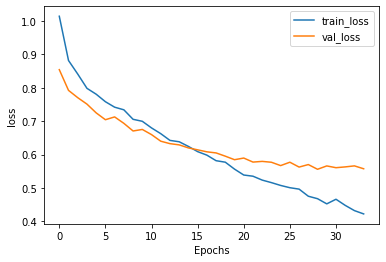

In [391]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(['train_'+metric, 'val_'+metric])
    plt.show()
    
plot_graphs(history, 'loss')
    
#plot_graphs(history, 'accuracy')

In [389]:
# Predict on unlabelled data set

test_emb = text_to_seq(tokenizer, text_corpus =  test.text, max_len = max_len)
pred_test = model.predict(test_emb)
submission_df = pd.read_csv('../input/sample_submission.csv')

submission_df.iloc[:, [1,2,3]] = pred_test

submission_df.to_csv('submit.csv', index=False)

In [394]:
## One bidirectional LSTM layer followed by two dense layers, with the final dense layer being the one with softmax activation

vocab_len = len(word_index) + 1
embedding_matrix = create_embedding_matrix(word_to_vec_map, word_index, emb_dim)
embedding_layer  = Embedding(vocab_len, emb_dim, weights=[embedding_matrix], 
                                 input_length=max_len, trainable = False)                             
model2 = Sequential()
model2.add(embedding_layer)
model2.add(Bidirectional(LSTM(64, recurrent_dropout=0.5, return_sequences=False)))
model2.add(Dropout(rate = 0.6))
model2.add(Dense(256, activation = 'relu'))
model2.add(Dropout(rate = 0.6))   
model2.add(Dense(units = 3, activation = 'softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history2 = model2.fit(X_train_emb, Y_train_oh, batch_size=128, epochs=50, verbose=1, 
          validation_data=(X_test_emb, Y_test_oh), callbacks=[early_stop])

Train on 15663 samples, validate on 3916 samples
Epoch 1/50
15663/15663 [==============================] - 159s 10ms/step - loss: 1.0470 - val_loss: 0.9197
Epoch 2/50
15663/15663 [==============================] - 193s 12ms/step - loss: 0.9362 - val_loss: 0.8276
Epoch 3/50
15663/15663 [==============================] - 175s 11ms/step - loss: 0.8726 - val_loss: 0.7880
Epoch 4/50
15663/15663 [==============================] - 145s 9ms/step - loss: 0.8328 - val_loss: 0.7581
Epoch 5/50
15663/15663 [==============================] - 173s 11ms/step - loss: 0.8110 - val_loss: 0.7322
Epoch 6/50
15663/15663 [==============================] - 180s 11ms/step - loss: 0.7888 - val_loss: 0.7248
Epoch 7/50
15663/15663 [==============================] - 189s 12ms/step - loss: 0.7671 - val_loss: 0.7002
Epoch 8/50
15663/15663 [==============================] - 181s 12ms/step - loss: 0.7440 - val_loss: 0.6934
Epoch 9/50
15663/15663 [==============================] - 164s 10ms/step - loss: 0.7307 - val_lo

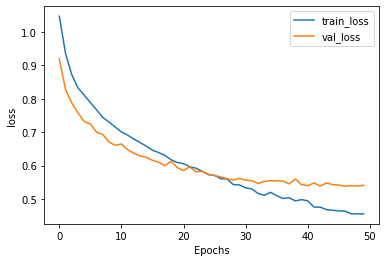

In [395]:
plot_graphs(history2, 'loss')

In [397]:
## One GRU  layer followed by two dense layers, with the final dense layer being the one with softmax activation
model3 = Sequential()
model3.add(embedding_layer)
model3.add(GRU(256, recurrent_dropout=0.5, return_sequences=False))
model3.add(Dropout(rate = 0.6))
model3.add(Dense(256, activation = 'relu'))
model3.add(Dropout(rate = 0.6))   
model3.add(Dense(units = 3, activation = 'softmax'))

model3.compile(loss='categorical_crossentropy', optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history3 = model3.fit(X_train_emb, Y_train_oh, batch_size=128, epochs=50, verbose=1, 
          validation_data=(X_test_emb, Y_test_oh), callbacks=[early_stop])

In [ ]:
plot_graphs(history3, 'loss')